In [1]:
import os 
import duckdb_query_graph
import json
import csv
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib
import math
import pylab
import seaborn as sns
import re

In [2]:
tum_colors = ["#0065BD", "#CCCCC6"]
sns.set_theme(font='serif')

In [3]:
cwd = os.getcwd()
cwd

'/Users/chuyinghe/Documents/duckdb-master-rl/chuying/visualization/0911'

In [4]:
directory = cwd + "/data.csv"
data= pd.read_csv(directory)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14726 entries, 0 to 14725
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Query            14726 non-null  object 
 1   Optimizer        14726 non-null  object 
 2   Loop             7509 non-null   float64
 3   JoinOrder        14726 non-null  object 
 4   PreparationTime  14726 non-null  float64
 5   ExecutionTime    14726 non-null  float64
 6   TotalTime        14726 non-null  float64
dtypes: float64(4), object(3)
memory usage: 805.5+ KB


# 0. Preprocessing
Add edge and table amount into data.

### Tidy Join Order

In [5]:
data['JoinOrder'] =  [re.sub(r'-+','-', str(x)) for x in data['JoinOrder']]
data.head()

,Query,Optimizer,Loop,JoinOrder,PreparationTime,ExecutionTime,TotalTime
0,1a.sql,DuckDB,NaN,4-3-2-1-0-,0.999,660.461,661.477
1,9d.sql,DuckDB,NaN,7-4-3-6-2-1-5-0-,4.170,3422.640,3426.830
2,19b.sql,DuckDB,NaN,2-1-8-7-0-9-6-5-4-3-,4.993,58044.800,58049.800
3,29c.sql,DuckDB,NaN,5-4-15-14-0-8-13-11-7-12-9-10-6-2-1-3-16-,5.563,58212.200,58217.700
4,23a.sql,DuckDB,NaN,8-4-9-5-7-2-3-10-6-1-0-,4.632,56732.000,56736.700


### Add TableAmount

In [6]:
conditions_table = [
    ( data['Query'].isin(['3a.sql','3b.sql','3c.sql']) ),
    ( data['Query'].isin(['1a.sql','1b.sql','1c.sql','1d.sql','2a.sql','2b.sql','2c.sql','2d.sql',
                          '4a.sql','4b.sql','4c.sql','5a.sql','5b.sql','5c.sql','6a.sql','6b.sql',
                          '6c.sql','6d.sql','6e.sql','6f.sql']) ),
    ( data['Query'].isin(['32a.sql','32b.sql']) ),
    ( data['Query'].isin(['8a.sql','8b.sql','8c.sql','8d.sql','10a.sql','10b.sql','10c.sql',
                          '17a.sql','17b.sql','17c.sql','17d.sql','17e.sql','17f.sql','18a.sql',
                          '18b.sql','18c.sql']) ),
    ( data['Query'].isin(['7a.sql','7b.sql','7c.sql','9a.sql','9b.sql','9c.sql','9d.sql','11a.sql',
                          '11b.sql','11c.sql','11d.sql','12a.sql','12b.sql','12c.sql','14a.sql',
                          '14b.sql','14c.sql','16a.sql','16b.sql','16c.sql','16d.sql']) ),
    ( data['Query'].isin(['13a.sql','13b.sql','13c.sql','13d.sql','15a.sql','15b.sql','15c.sql',
                          '15d.sql','21a.sql','21b.sql','21c.sql','25a.sql','25b.sql','25c.sql']) ),
    ( data['Query'].isin(['19a.sql','19b.sql','19c.sql','19d.sql','20a.sql','20b.sql','20c.sql']) ),
    ( data['Query'].isin(['22a.sql','22b.sql','22c.sql','22d.sql','23a.sql','23b.sql','23c.sql',
                          '31a.sql','31b.sql','31c.sql']) ),
    ( data['Query'].isin(['24a.sql','24b.sql','26a.sql','26b.sql','26c.sql','27a.sql','27b.sql',
                          '27c.sql','30a.sql','30b.sql','30c.sql']) ),
    ( data['Query'].isin(['33a.sql','33b.sql','33c.sql']) ),
    ( data['Query'].isin(['28a.sql','28b.sql','28c.sql']) ),
    ( data['Query'].isin(['29a.sql','29b.sql','29c.sql']) )
]

values_table = [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17]
data['TableAmount'] = np.select(conditions_table, values_table)
data.head()
#print(data['TableAmount'].unique().size)

,Query,Optimizer,Loop,JoinOrder,PreparationTime,ExecutionTime,TotalTime,TableAmount
0,1a.sql,DuckDB,NaN,4-3-2-1-0-,0.999,660.461,661.477,5
1,9d.sql,DuckDB,NaN,7-4-3-6-2-1-5-0-,4.170,3422.640,3426.830,8
2,19b.sql,DuckDB,NaN,2-1-8-7-0-9-6-5-4-3-,4.993,58044.800,58049.800,10
3,29c.sql,DuckDB,NaN,5-4-15-14-0-8-13-11-7-12-9-10-6-2-1-3-16-,5.563,58212.200,58217.700,17
4,23a.sql,DuckDB,NaN,8-4-9-5-7-2-3-10-6-1-0-,4.632,56732.000,56736.700,11


### Add EdgeAmount

In [7]:
conditions_edge = [
    ( data['Query'].isin(['3a.sql','3b.sql','3c.sql']) ),
    ( data['Query'].isin(['1a.sql','1b.sql','1c.sql','1d.sql','2a.sql','2b.sql','2c.sql','2d.sql','4a.sql',
                          '4b.sql','4c.sql','5a.sql','5b.sql','5c.sql','6a.sql','6b.sql','6c.sql','6d.sql',
                          '6e.sql','6f.sql']) ),
    ( data['Query'].isin(['32a.sql','32b.sql']) ),
    ( data['Query'].isin(['10a.sql','10b.sql','10c.sql']) ),
    ( data['Query'].isin(['8a.sql','8b.sql','8c.sql','8d.sql']) ),
    ( data['Query'].isin(['17a.sql','17b.sql','17c.sql','17d.sql','17e.sql','17f.sql','18a.sql','18b.sql',
                          '18c.sql','9a.sql','9b.sql','9c.sql','9d.sql']) ),
    ( data['Query'].isin(['11a.sql','11b.sql','11c.sql','11d.sql','12a.sql','12b.sql','12c.sql','14a.sql',
                          '14b.sql','14c.sql']) ),
    ( data['Query'].isin(['7a.sql','7b.sql','7c.sql','16a.sql','16b.sql','16c.sql','16d.sql','13a.sql',
                          '13b.sql','13c.sql','13d.sql']) ),
    ( data['Query'].isin(['20a.sql','20b.sql','20c.sql']) ),
    ( data['Query'].isin(['19a.sql','19b.sql','19c.sql','19d.sql']) ),
    ( data['Query'].isin(['15a.sql','15b.sql','15c.sql','15d.sql','21a.sql','21b.sql','21c.sql','25a.sql',
                          '25b.sql','25c.sql']) ),
    ( data['Query'].isin(['22a.sql','22b.sql','22c.sql','22d.sql','23a.sql','23b.sql','23c.sql']) ),
    ( data['Query'].isin(['26a.sql','26b.sql','26c.sql']) ),
    ( data['Query'].isin(['24a.sql','24b.sql']) ),
    ( data['Query'].isin(['33a.sql','33b.sql','33c.sql']) ),
    ( data['Query'].isin(['31a.sql','31b.sql','31c.sql']) ),
    ( data['Query'].isin(['27a.sql','27b.sql','27c.sql','30a.sql','30b.sql','30c.sql']) ),
    ( data['Query'].isin(['28a.sql','28b.sql','28c.sql']) ),
    ( data['Query'].isin(['29a.sql','29b.sql','29c.sql']) )
]
values_edge = [4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,
              20,21,23,28]
data['EdgeAmount'] = np.select(conditions_edge, values_edge)
data.head()
#print(data['EdgeAmount'].unique().size)

,Query,Optimizer,Loop,JoinOrder,PreparationTime,ExecutionTime,TotalTime,TableAmount,EdgeAmount
0,1a.sql,DuckDB,NaN,4-3-2-1-0-,0.999,660.461,661.477,5,5
1,9d.sql,DuckDB,NaN,7-4-3-6-2-1-5-0-,4.170,3422.640,3426.830,8,9
2,19b.sql,DuckDB,NaN,2-1-8-7-0-9-6-5-4-3-,4.993,58044.800,58049.800,10,13
3,29c.sql,DuckDB,NaN,5-4-15-14-0-8-13-11-7-12-9-10-6-2-1-3-16-,5.563,58212.200,58217.700,17,28
4,23a.sql,DuckDB,NaN,8-4-9-5-7-2-3-10-6-1-0-,4.632,56732.000,56736.700,11,16


### Add label
for which queries is skinnerDB better?

In [8]:
# FOR EACH QUERY: 
# 1) calculate avg
# 2) find out which Optimizer is faster
data_avg = data.groupby(['Query'])

In [9]:
skinner_fast_query=[]
duck_fast_query=[]
rest_query = []

def findBetterOptimizerForPhase(attr):
    time_DuckDB = 0;
    time_SkinnerDB = 0;
    for query, group_query in data_avg:
        data_query = group_query.groupby('Optimizer')

        for optimizer, group_optimizer in data_query:
            if optimizer == 'DuckDB':
                time_DuckDB = group_optimizer[attr].mean()
            elif optimizer == 'SkinnerDB':
                time_SkinnerDB = group_optimizer[attr].mean()

        if(time_SkinnerDB<time_DuckDB):
            skinner_fast_query.append(query)
        elif(time_SkinnerDB>time_DuckDB):
            duck_fast_query.append(query)
        else:
            rest_query.append(query)

        #print(query, time_DuckDB, time_SkinnerDB)

#     print('skinner_fast_query (',len(skinner_fast_query),'):\n', skinner_fast_query, '\n')
#     print('duck_fast_query (', len(duck_fast_query),'):\n',duck_fast_query, '\n')
#     print('rest_query (', len(rest_query),'):\n',rest_query)
    
def addLabel(attr, label_name, label_skinner, label_duck):
    findBetterOptimizerForPhase(attr) # fill up the 3 lists
    
    # LABEL EACH ROW: WHICH OPTIMIZER IS BETTER:
    # if using DUCKDB is quicker, then we label this row as "duck"
    # otherwise label it as "skinner"
    conditions_label = [
        ( data['Query'].isin(skinner_fast_query) ),
        ( data['Query'].isin(duck_fast_query) ),
    ]
    values_label = [label_skinner, label_duck]
    data[label_name] = np.select(conditions_label, values_label)
    data

In [10]:
# ADD LABELS: 1 means Skinner is faster
skinner_fast_query=[]
duck_fast_query=[]
rest_query = []
addLabel('TotalTime', 'total_label', 1, 0)
print('-------------------TotalTime-------------------')
print('skinner_fast_query (',len(skinner_fast_query),'):\n', skinner_fast_query, '\n')
print('duck_fast_query (', len(duck_fast_query),'):\n',duck_fast_query, '\n')
print('rest_query (', len(rest_query),'):\n',rest_query)
    
    
skinner_fast_query=[]
duck_fast_query=[]
rest_query = []
print('-------------------PreparationTime-------------------')
addLabel('PreparationTime', 'preparation_label', 1, 0)
print('skinner_fast_query (',len(skinner_fast_query),'):\n', skinner_fast_query, '\n')
print('duck_fast_query (', len(duck_fast_query),'):\n',duck_fast_query, '\n')
print('rest_query (', len(rest_query),'):\n',rest_query)

skinner_fast_query=[]
duck_fast_query=[]
rest_query = []
print('-------------------ExecutionTime-------------------')
addLabel('ExecutionTime', 'execution_label', 1, 0)
print('skinner_fast_query (',len(skinner_fast_query),'):\n', skinner_fast_query, '\n')
print('duck_fast_query (', len(duck_fast_query),'):\n',duck_fast_query, '\n')
print('rest_query (', len(rest_query),'):\n',rest_query)

print('Skinner is faster in: ')
print('total_label: ', sum(data['total_label']))
print('preparation_label: ', sum(data['preparation_label']))
print('execution_label: ', sum(data['execution_label']))

-------------------TotalTime-------------------
skinner_fast_query ( 91 ):
 ['10a.sql', '10b.sql', '10c.sql', '11a.sql', '11b.sql', '11d.sql', '12a.sql', '12b.sql', '12c.sql', '13a.sql', '14a.sql', '14b.sql', '14c.sql', '15a.sql', '15b.sql', '15c.sql', '15d.sql', '17c.sql', '17d.sql', '18a.sql', '18b.sql', '18c.sql', '19a.sql', '19b.sql', '19c.sql', '19d.sql', '1a.sql', '1b.sql', '1c.sql', '1d.sql', '20c.sql', '21a.sql', '21b.sql', '21c.sql', '22a.sql', '22b.sql', '22c.sql', '22d.sql', '23a.sql', '23b.sql', '23c.sql', '24a.sql', '24b.sql', '25a.sql', '25b.sql', '25c.sql', '27a.sql', '27b.sql', '27c.sql', '28a.sql', '28b.sql', '28c.sql', '29a.sql', '29b.sql', '29c.sql', '2a.sql', '2b.sql', '2c.sql', '2d.sql', '30a.sql', '30b.sql', '30c.sql', '31a.sql', '31b.sql', '31c.sql', '32a.sql', '32b.sql', '3a.sql', '3b.sql', '3c.sql', '4a.sql', '4b.sql', '4c.sql', '5a.sql', '5b.sql', '5c.sql', '6a.sql', '6c.sql', '6e.sql', '6f.sql', '7a.sql', '7b.sql', '7c.sql', '8a.sql', '8b.sql', '8c.sql', '8d.

### Add ratio prep-exec

In [11]:
# REAL RATIO
data['ratio'] = data['PreparationTime']/data['ExecutionTime']
print(max(data['ratio']), min(data['ratio']))

0.06798295521427619 1.0049882372681098e-05


In [12]:
# EIDT RATIO: for better comparison between duck-prone & skinner-prone
data['ratio'] = np.log10( (10**5) * data['ratio'] )
data['ratio'] = np.log10( (10**3) * data['ratio'] )

print("ratio: ", max(data['ratio']), min(data['ratio']))
data.head()

ratio:  3.5834708359596283 0.3346504766876591


,Query,Optimizer,Loop,JoinOrder,PreparationTime,ExecutionTime,TotalTime,TableAmount,EdgeAmount,total_label,preparation_label,execution_label,ratio
0,1a.sql,DuckDB,NaN,4-3-2-1-0-,0.999,660.461,661.477,5,5,1,0,1,3.338400
1,9d.sql,DuckDB,NaN,7-4-3-6-2-1-5-0-,4.170,3422.640,3426.830,8,9,1,0,1,3.319267
2,19b.sql,DuckDB,NaN,2-1-8-7-0-9-6-5-4-3-,4.993,58044.800,58049.800,10,13,1,0,1,2.970625
3,29c.sql,DuckDB,NaN,5-4-15-14-0-8-13-11-7-12-9-10-6-2-1-3-16-,5.563,58212.200,58217.700,17,28,1,0,1,2.991357
4,23a.sql,DuckDB,NaN,8-4-9-5-7-2-3-10-6-1-0-,4.632,56732.000,56736.700,11,16,1,0,1,2.959966


# 1. Comparison

## 1.1 Average boxplot

In [13]:
print("PreparationTime: ", max(data['PreparationTime']), min(data['PreparationTime']))
print("ExecutionTime: ", max(data['ExecutionTime']), min(data['ExecutionTime']))
print("TotalTime: ", max(data['TotalTime']), min(data['TotalTime']))

PreparationTime:  25.771 0.419
ExecutionTime:  253818.0 78.493
TotalTime:  253856.0 82.379


In [14]:
green_diamond = dict(markerfacecolor='white', marker='o', linestyle='none')

def plotTime(data, attr, attr_name):
    boxplot = sns.boxplot(x = data["Optimizer"],
                y = data[attr],
                #hue = my_df[hue],
                palette = tum_colors,
                flierprops=green_diamond, whis =1)
    #boxplot.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.ticklabel_format(style='plain', axis='y')

    boxplot.axes.set_title("Average "+attr_name+" of JOB")
    boxplot.set_xlabel("Join Order Optimizer")
    boxplot.set_ylabel("Average "+attr_name+"(ms)")

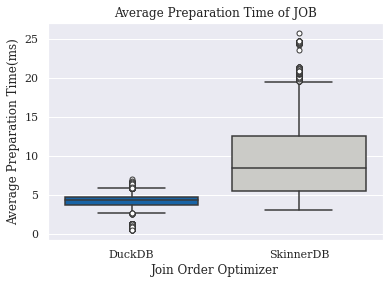

In [15]:
plotTime(data, "PreparationTime", "Preparation Time")
plt.savefig("statistic-PreparationTime.pdf")

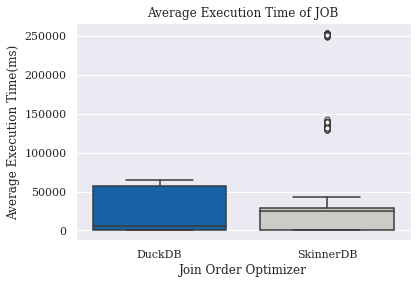

In [16]:
plotTime(data, "ExecutionTime", "Execution Time")
plt.savefig("statistic-ExecutionTime.pdf")

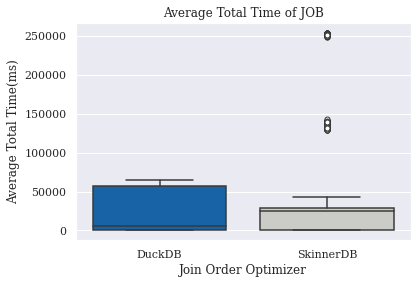

In [20]:
plotTime(data, "TotalTime", "Total Time")
plt.savefig("statistic-TotalTime.pdf")

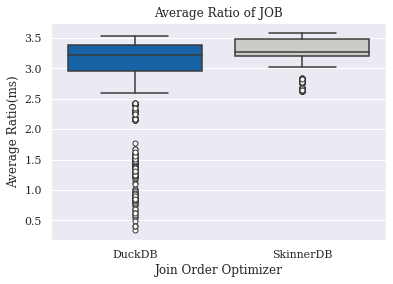

In [26]:
plotTime(data, "ratio", "Ratio") # Ratio = PreparationTime:ExecutionTime



In [21]:
# OUTLIERS
def printOutlier(col):
    # finding the 1st quartile
    arr = data[col]
    q1 = np.quantile(arr, 0.25)

    # finding the 3rd quartile
    q3 = np.quantile(arr, 0.75)
    med = np.median(arr)

    # finding the iqr region
    iqr = q3-q1

    # finding upper and lower whiskers
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    outliers = arr[(arr <= lower_bound) | (arr >= upper_bound)]
    return data[data[col].isin(outliers)].head()
    #print(outliers)

In [22]:
outlier_prep = printOutlier('PreparationTime')
outlier_exec = printOutlier('ExecutionTime')
outlier_total = printOutlier('TotalTime')
print('outlier prep: ' ,outlier_prep.shape, ', query: ' ,outlier_prep['Query'].unique())
print('outlier exec: ' ,outlier_exec.shape, ', query: ' ,outlier_exec['Query'].unique())
print('outlier total: ' ,outlier_total.shape, ', query: ' ,outlier_total['Query'].unique())

outlier prep:  (5, 13) , query:  ['30c.sql' '29b.sql' '28a.sql' '33c.sql' '28c.sql']
outlier exec:  (5, 13) , query:  ['17e.sql' '16a.sql' '16d.sql' '16b.sql']
outlier total:  (5, 13) , query:  ['17e.sql' '16a.sql' '16d.sql' '16b.sql']


## 1.2 Average stacked horizontal bar

In [23]:
data_duck = data[data["Optimizer"]=="DuckDB"]
data_skinner = data[data["Optimizer"]=="SkinnerDB"]

In [24]:
avg_prep_duck = data_duck["PreparationTime"].mean()
avg_exec_duck = data_duck["ExecutionTime"].mean()
avg_total_duck = data_duck["TotalTime"].mean()

avg_prep_skinner = data_skinner["PreparationTime"].mean()
avg_exec_skinner = data_skinner["ExecutionTime"].mean()
avg_total_skinner = data_skinner["TotalTime"].mean()


print(avg_prep_duck, avg_exec_duck, avg_prep_duck+avg_exec_duck,"~~",avg_total_duck)
print(avg_prep_skinner, avg_exec_skinner,avg_prep_skinner+avg_exec_skinner,"~~", avg_total_skinner)

3.7983549951503393 27603.241778439795 27607.040133434944 ~~ 27607.057453096855
9.452854041816487 20345.456713810094 20354.90956785191 ~~ 20362.72179184978


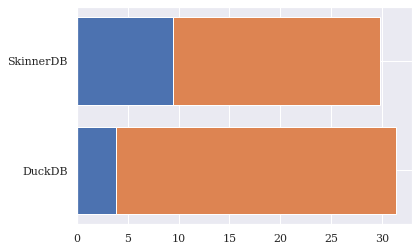

In [25]:
plt.barh(["DuckDB","SkinnerDB"], [avg_prep_duck,avg_prep_skinner]) #prep
#execution 相对来说太多了
plt.barh(["DuckDB","SkinnerDB"], [avg_exec_duck/1000,avg_exec_skinner/1000], 
         left=[avg_prep_duck,avg_prep_skinner]) #exec
plt.savefig("statistic-2.pdf")

## 1.3 multi-plot / query

In [298]:
# (1) Facet Grid 
# it generates multiple mini-graph: column * row can generate combinations
#g = sns.FacetGrid(data, col="Query", col_wrap=4)
#g.map(sns.boxplot, "Query", "TotalTime", order=[1, 2, 3], color=".3", ci=None)
#g.map(sns.boxplot, "TotalTime")

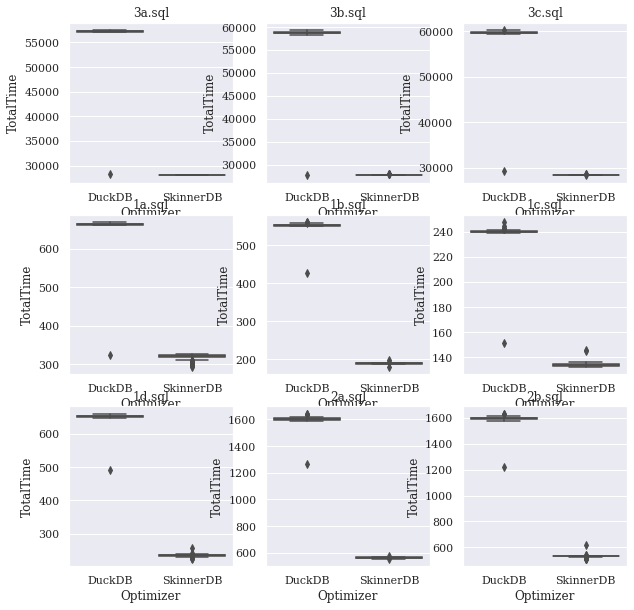

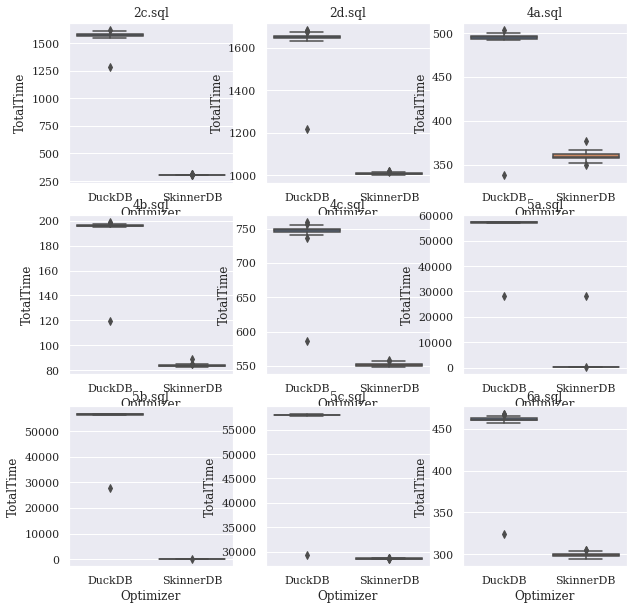

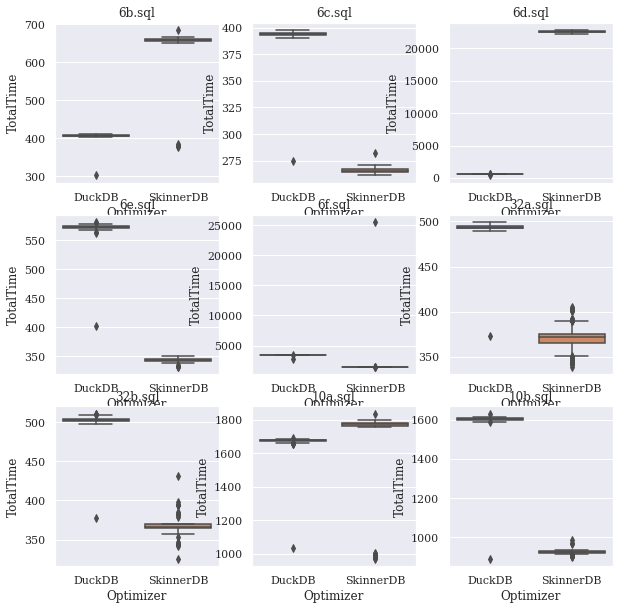

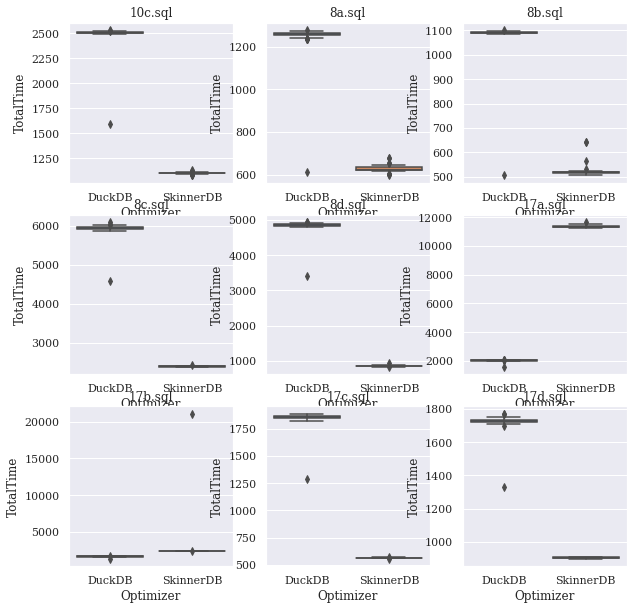

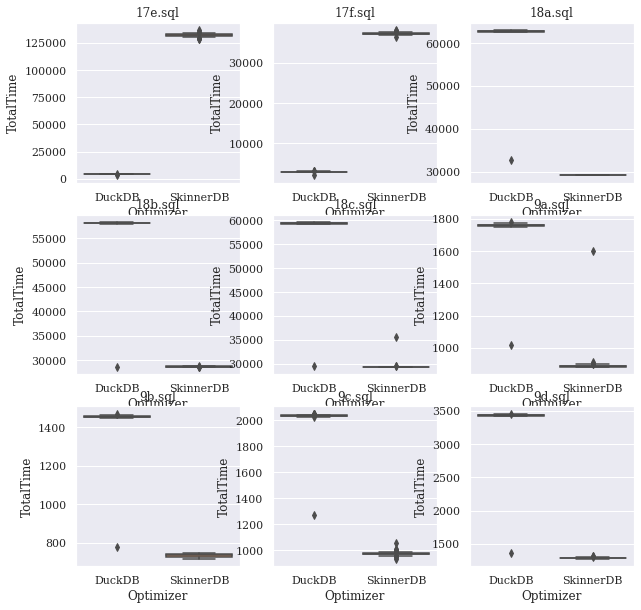

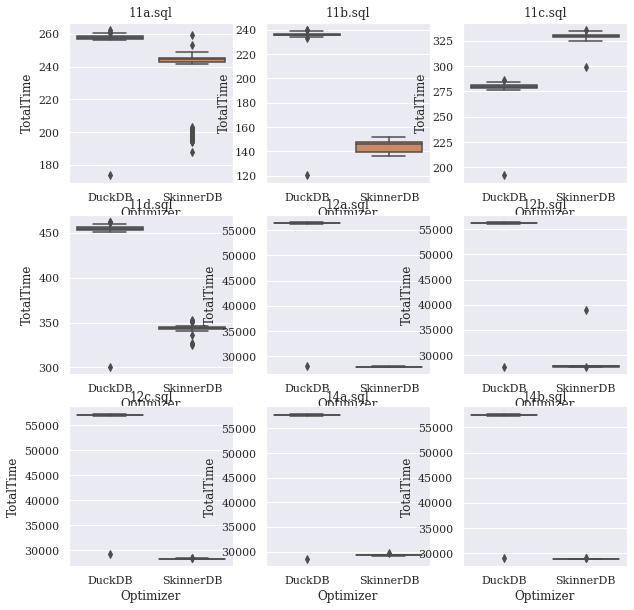

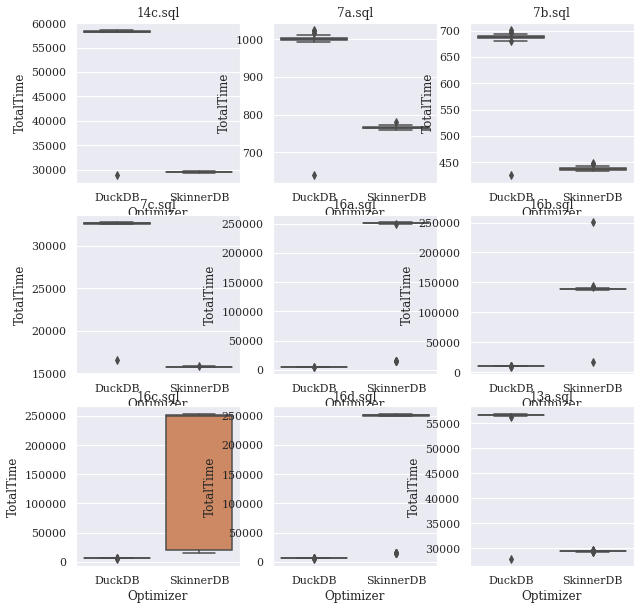

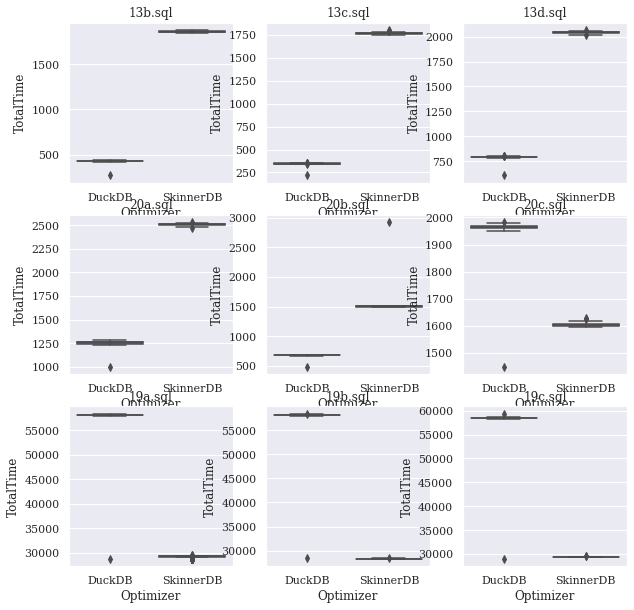

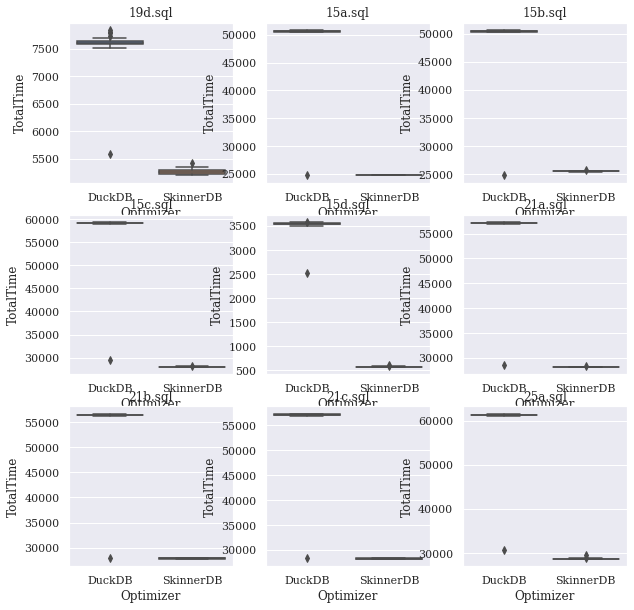

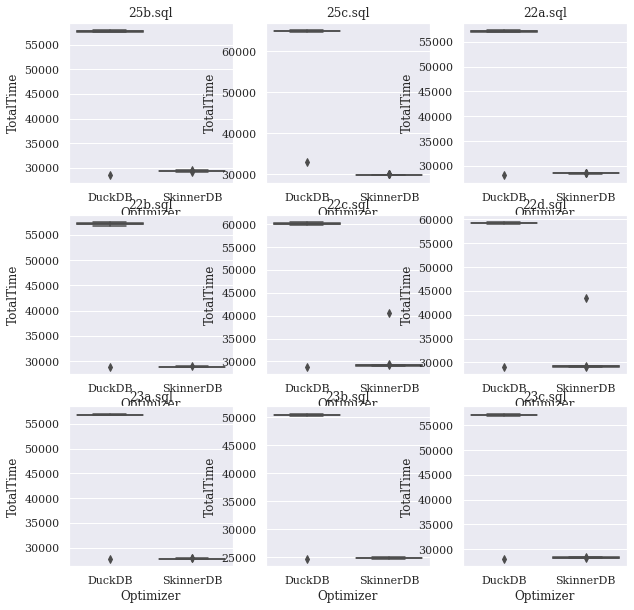

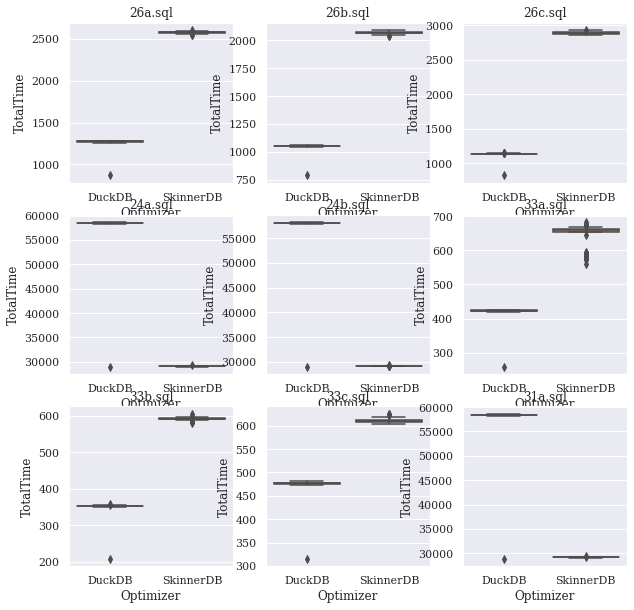

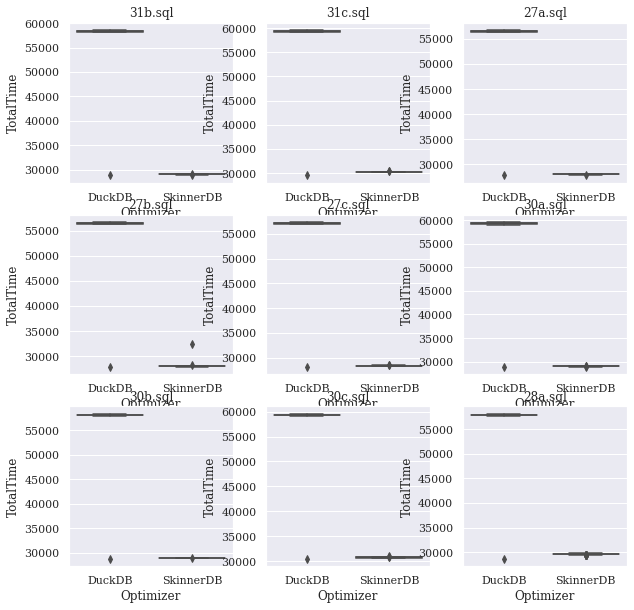

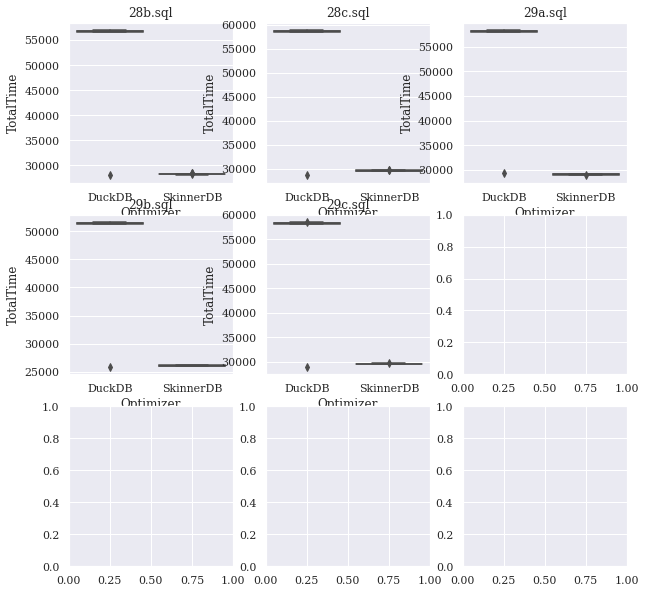

In [333]:
# (2) subplots 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="3a.sql"], orient='v', ax=axes[0, 0]).set_title("3a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="3b.sql"], orient='v', ax=axes[0, 1]).set_title("3b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="3c.sql"], orient='v', ax=axes[0, 2]).set_title("3c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="1a.sql"], orient='v', ax=axes[1, 0]).set_title("1a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="1b.sql"], orient='v', ax=axes[1, 1]).set_title("1b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="1c.sql"], orient='v', ax=axes[1, 2]).set_title("1c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="1d.sql"], orient='v', ax=axes[2, 0]).set_title("1d.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="2a.sql"], orient='v', ax=axes[2, 1]).set_title("2a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="2b.sql"], orient='v', ax=axes[2, 2]).set_title("2b.sql")
plt.savefig("total_time_all_queries/1.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="2c.sql"], orient='v', ax=axes[0, 0]).set_title("2c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="2d.sql"], orient='v', ax=axes[0, 1]).set_title("2d.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="4a.sql"], orient='v', ax=axes[0, 2]).set_title("4a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="4b.sql"], orient='v', ax=axes[1, 0]).set_title("4b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="4c.sql"], orient='v', ax=axes[1, 1]).set_title("4c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="5a.sql"], orient='v', ax=axes[1, 2]).set_title("5a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="5b.sql"], orient='v', ax=axes[2, 0]).set_title("5b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="5c.sql"], orient='v', ax=axes[2, 1]).set_title("5c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="6a.sql"], orient='v', ax=axes[2, 2]).set_title("6a.sql")
plt.savefig("total_time_all_queries/2.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="6b.sql"], orient='v', ax=axes[0, 0]).set_title("6b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="6c.sql"], orient='v', ax=axes[0, 1]).set_title("6c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="6d.sql"], orient='v', ax=axes[0, 2]).set_title("6d.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="6e.sql"], orient='v', ax=axes[1, 0]).set_title("6e.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="6f.sql"], orient='v', ax=axes[1, 1]).set_title("6f.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="32a.sql"], orient='v', ax=axes[1, 2]).set_title("32a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="32b.sql"], orient='v', ax=axes[2, 0]).set_title("32b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="10a.sql"], orient='v', ax=axes[2, 1]).set_title("10a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="10b.sql"], orient='v', ax=axes[2, 2]).set_title("10b.sql")
plt.savefig("total_time_all_queries/3.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="10c.sql"], orient='v', ax=axes[0,0 ]).set_title("10c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="8a.sql"], orient='v', ax=axes[0, 1]).set_title("8a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="8b.sql"], orient='v', ax=axes[0, 2]).set_title("8b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="8c.sql"], orient='v', ax=axes[1, 0]).set_title("8c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="8d.sql"], orient='v', ax=axes[1, 1]).set_title("8d.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="17a.sql"], orient='v', ax=axes[1, 2]).set_title("17a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="17b.sql"], orient='v', ax=axes[2, 0]).set_title("17b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="17c.sql"], orient='v', ax=axes[2, 1]).set_title("17c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="17d.sql"], orient='v', ax=axes[2, 2]).set_title("17d.sql")
plt.savefig("total_time_all_queries/4.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="17e.sql"], orient='v', ax=axes[0, 0]).set_title("17e.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="17f.sql"], orient='v', ax=axes[0, 1]).set_title("17f.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="18a.sql"], orient='v', ax=axes[0, 2]).set_title("18a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="18b.sql"], orient='v', ax=axes[1, 0]).set_title("18b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="18c.sql"], orient='v', ax=axes[1, 1]).set_title("18c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="9a.sql"], orient='v', ax=axes[1, 2]).set_title("9a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="9b.sql"], orient='v', ax=axes[2, 0]).set_title("9b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="9c.sql"], orient='v', ax=axes[2, 1]).set_title("9c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="9d.sql"], orient='v', ax=axes[2, 2]).set_title("9d.sql")
plt.savefig("total_time_all_queries/5.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="11a.sql"], orient='v', ax=axes[0, 0]).set_title("11a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="11b.sql"], orient='v', ax=axes[0, 1]).set_title("11b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="11c.sql"], orient='v', ax=axes[0, 2]).set_title("11c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="11d.sql"], orient='v', ax=axes[1, 0]).set_title("11d.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="12a.sql"], orient='v', ax=axes[1, 1]).set_title("12a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="12b.sql"], orient='v', ax=axes[1, 2]).set_title("12b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="12c.sql"], orient='v', ax=axes[2, 0]).set_title("12c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="14a.sql"], orient='v', ax=axes[2, 1]).set_title("14a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="14b.sql"], orient='v', ax=axes[2, 2]).set_title("14b.sql")
plt.savefig("total_time_all_queries/6.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="14c.sql"], orient='v', ax=axes[0,0 ]).set_title("14c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="7a.sql"], orient='v', ax=axes[0, 1]).set_title("7a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="7b.sql"], orient='v', ax=axes[0, 2]).set_title("7b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="7c.sql"], orient='v', ax=axes[1, 0]).set_title("7c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="16a.sql"], orient='v', ax=axes[1, 1]).set_title("16a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="16b.sql"], orient='v', ax=axes[1, 2]).set_title("16b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="16c.sql"], orient='v', ax=axes[2, 0]).set_title("16c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="16d.sql"], orient='v', ax=axes[2, 1]).set_title("16d.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="13a.sql"], orient='v', ax=axes[2, 2]).set_title("13a.sql")
plt.savefig("total_time_all_queries/7.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="13b.sql"], orient='v', ax=axes[0, 0]).set_title("13b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="13c.sql"], orient='v', ax=axes[0, 1]).set_title("13c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="13d.sql"], orient='v', ax=axes[0, 2]).set_title("13d.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="20a.sql"], orient='v', ax=axes[1, 0]).set_title("20a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="20b.sql"], orient='v', ax=axes[1, 1]).set_title("20b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="20c.sql"], orient='v', ax=axes[1, 2]).set_title("20c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="19a.sql"], orient='v', ax=axes[2, 0]).set_title("19a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="19b.sql"], orient='v', ax=axes[2, 1]).set_title("19b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="19c.sql"], orient='v', ax=axes[2, 2]).set_title("19c.sql")
plt.savefig("total_time_all_queries/8.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="19d.sql"], orient='v', ax=axes[0, 0]).set_title("19d.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="15a.sql"], orient='v', ax=axes[0, 1]).set_title("15a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="15b.sql"], orient='v', ax=axes[0, 2]).set_title("15b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="15c.sql"], orient='v', ax=axes[1, 0]).set_title("15c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="15d.sql"], orient='v', ax=axes[1, 1]).set_title("15d.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="21a.sql"], orient='v', ax=axes[1, 2]).set_title("21a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="21b.sql"], orient='v', ax=axes[2, 0]).set_title("21b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="21c.sql"], orient='v', ax=axes[2, 1]).set_title("21c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="25a.sql"], orient='v', ax=axes[2, 2]).set_title("25a.sql")
plt.savefig("total_time_all_queries/9.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="25b.sql"], orient='v', ax=axes[0, 0]).set_title("25b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="25c.sql"], orient='v', ax=axes[0, 1]).set_title("25c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="22a.sql"], orient='v', ax=axes[0, 2]).set_title("22a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="22b.sql"], orient='v', ax=axes[1, 0]).set_title("22b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="22c.sql"], orient='v', ax=axes[1, 1]).set_title("22c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="22d.sql"], orient='v', ax=axes[1, 2]).set_title("22d.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="23a.sql"], orient='v', ax=axes[2, 0]).set_title("23a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="23b.sql"], orient='v', ax=axes[2, 1]).set_title("23b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="23c.sql"], orient='v', ax=axes[2, 2]).set_title("23c.sql")
plt.savefig("total_time_all_queries/10.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="26a.sql"], orient='v', ax=axes[0, 0]).set_title("26a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="26b.sql"], orient='v', ax=axes[0, 1]).set_title("26b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="26c.sql"], orient='v', ax=axes[0, 2]).set_title("26c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="24a.sql"], orient='v', ax=axes[1, 0]).set_title("24a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="24b.sql"], orient='v', ax=axes[1, 1]).set_title("24b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="33a.sql"], orient='v', ax=axes[1, 2]).set_title("33a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="33b.sql"], orient='v', ax=axes[2, 0]).set_title("33b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="33c.sql"], orient='v', ax=axes[2, 1]).set_title("33c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="31a.sql"], orient='v', ax=axes[2, 2]).set_title("31a.sql")
plt.savefig("total_time_all_queries/11.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="31b.sql"], orient='v', ax=axes[0, 0]).set_title("31b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="31c.sql"], orient='v', ax=axes[0, 1]).set_title("31c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="27a.sql"], orient='v', ax=axes[0, 2]).set_title("27a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="27b.sql"], orient='v', ax=axes[1, 0]).set_title("27b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="27c.sql"], orient='v', ax=axes[1, 1]).set_title("27c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="30a.sql"], orient='v', ax=axes[1, 2]).set_title("30a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="30b.sql"], orient='v', ax=axes[2, 0]).set_title("30b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="30c.sql"], orient='v', ax=axes[2, 1]).set_title("30c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="28a.sql"], orient='v', ax=axes[2, 2]).set_title("28a.sql")
plt.savefig("total_time_all_queries/12.pdf")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="28b.sql"], orient='v', ax=axes[0, 0]).set_title("28b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="28c.sql"], orient='v', ax=axes[0, 1]).set_title("28c.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="29a.sql"], orient='v', ax=axes[0, 2]).set_title("29a.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="29b.sql"], orient='v', ax=axes[1, 0]).set_title("29b.sql")
ax = sns.boxplot(x="Optimizer", y="TotalTime", data=data[data["Query"]=="29c.sql"], orient='v', ax=axes[1, 1]).set_title("29c.sql")
plt.savefig("total_time_all_queries/13.pdf")


## 1.4 Why some query is better with DuckDB?

### Statistics

In [423]:
def plotDataRunFasterWithOptimizer(optimizer):
    data_optimizer=data[data['label']==optimizer]
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,10))
    ax = sns.histplot(data=data_optimizer['TableAmount'], ax=axes[0, 0])
    ax = sns.histplot(data=data_optimizer['EdgeAmount'], ax=axes[0, 1])
    ax = sns.histplot(data=data_optimizer['Loop'], ax=axes[0, 2])
    
    ax = sns.boxplot(x=data_optimizer['Optimizer'], y=data_optimizer['ratio'], ax=axes[1, 0])
    ax = sns.boxplot(x=data_optimizer['Optimizer'] , y=data_optimizer['PreparationTime'], ax=axes[1, 1])
    ax = sns.boxplot(x=data_optimizer['Optimizer'] , y=data_optimizer['ExecutionTime'], ax=axes[1, 2])
    ax = sns.boxplot(x=data_optimizer['Optimizer'] , y=data_optimizer['TotalTime'], ax=axes[1, 3])
    fig_name = 'comparison/case_' + optimizer + '_faster.pdf'
    plt.savefig(fig_name)

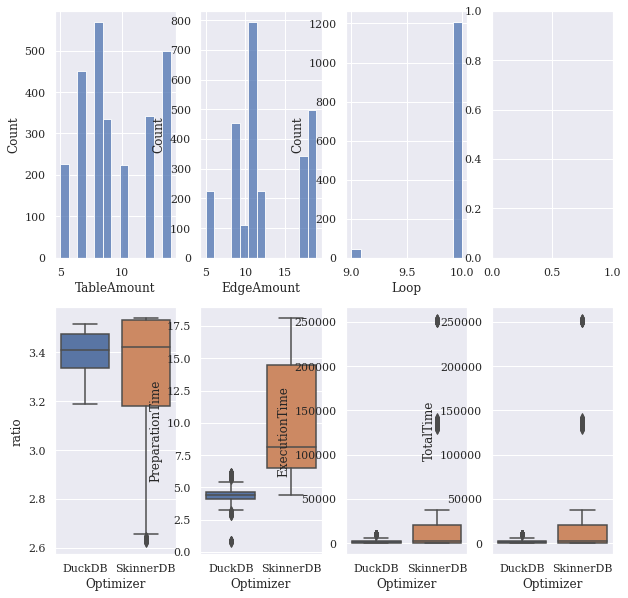

In [424]:
plotDataRunFasterWithOptimizer('duck')

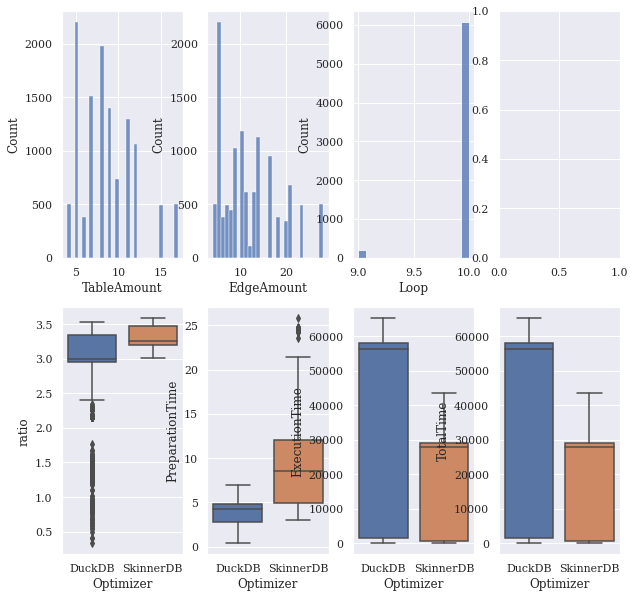

In [425]:
plotDataRunFasterWithOptimizer('skinner')

### Conclustion
Duck-prone queries have following problem:\
- Skinner Preparation took too long(longer than Skinner-prone queries)
- Skinner Execution is slower than Duck.

In [558]:
#compare_1 = ''
#compare_2 = ''

def getTimeStatistic(prone_data): 
    # [0,0,0] represents [PreparationTime, ExecutionTime, TotalTime]
    time_statistic_dict = {'duck_prone': [0, 0, 0],    # num of queries that runns faster in duck's phase
                       'skinner_prone': [0, 0, 0]} # num of queries that runns faster in skinner's phase
    time_statistic_df = pd.DataFrame(time_statistic_dict)
    
    queries = prone_data['Query'].unique()
    
    # skinner -----------------------   
    for query in queries:
        skinner_prep = prone_data[(prone_data['Query']==query)].iloc[0]['preparation_label']
        time_statistic_df['skinner_prone'][0] += skinner_prep
        skinner_exec = prone_data[(prone_data['Query']==query)].iloc[0]['execution_label']
        time_statistic_df['skinner_prone'][1] += skinner_exec
        skinner_total = prone_data[(prone_data['Query']==query)].iloc[0]['total_label']
        time_statistic_df['skinner_prone'][2] += skinner_total
        #print(query, ': total=',skinner_total,', prep', skinner_prep,', exec',skinner_exec)
        
    # duck ----------------------- 
    time_statistic_df['duck_prone'][0] = len(queries) - time_statistic_df['skinner_prone'][0]
    time_statistic_df['duck_prone'][1] = len(queries) - time_statistic_df['skinner_prone'][1]
    time_statistic_df['duck_prone'][2] = len(queries) - time_statistic_df['skinner_prone'][2]
    return time_statistic_df

In [560]:
# Queries that runs faster in DUCK
duck_prone_data = data[data['total_label'] ==0]
# print(len(duck_prone_data['Query'].unique()))

duck_prone_statistic = getTimeStatistic(duck_prone_data)
duck_prone_statistic


,duck_prone,skinner_prone
0,22,0
1,22,0
2,22,0


In [13]:
# Queries that runs faster in SKINNER
skinner_prone_data = data[data['total_label']==1]
# print(len(skinner_prone_data['Query'].unique()))

skinner_prone_statistic = getTimeStatistic(skinner_prone_data)
print(skinner_prone_data['preparation_label'].unique())
skinner_prone_data

KeyError: 'total_label'

### Chosen Join Order
for each query: 
   1) find most frequent join_order in Skinner\
   2) find most frequent join_order in Duck\
   3) does (1) equal to (2)\
   4) which runs faster?\

In [221]:
query_data = data[data['Query'] == '3b.sql']
optimizer_query_list = query_data[query_data['Optimizer'] == 'SkinnerDB']['JoinOrder']
optimizer_query_list
print(mostFrequentJoinOrderByOptimizer(optimizer_query_list))


2-3-0-1-


In [311]:
job_query = data['Query'].unique()
# job_query.size

for query in job_query:
    query_data = data[data['Query'] == query]
    skinner_query_data = query_data[query_data['Optimizer'] == 'SkinnerDB']['JoinOrder']
    duck_query_data = query_data[query_data['Optimizer'] == 'DuckDB']['JoinOrder']
    skinner_jo = mostFrequentJoinOrderByOptimizer(skinner_query_data)
    duck_jo = mostFrequentJoinOrderByOptimizer(duck_query_data)
    
    comparison = ' same join order.' if (skinner_jo==duck_jo) else ' different join order.🌟'
 
    print(query, 'runs faster in', ''.join(query_data['label'].unique()), '. They chooses', comparison)
    print('   - Skinner choose join order = ', skinner_jo)
    print('   - Duck choose join order = ', duck_jo)

30c.sql runs faster in skinner . They chooses  different join order.🌟
   - Skinner choose join order =  10-3-0-1-2-7-4-8-5-9-6-11-
   - Duck choose join order =  10-3-7-4-9-6-8-5-1-0-2-11-
6f.sql runs faster in skinner . They chooses  different join order.🌟
   - Skinner choose join order =  2-1-0-3-4-
   - Duck choose join order =  4-2-1-3-0-
22b.sql runs faster in skinner . They chooses  different join order.🌟
   - Skinner choose join order =  10-5-7-2-9-4-8-3-6-0-1-
   - Duck choose join order =  7-2-9-4-6-0-1-10-5-8-3-
24b.sql runs faster in skinner . They chooses  different join order.🌟
   - Skinner choose join order =  10-2-0-1-6-3-7-4-8-5-9-11-
   - Duck choose join order =  2-1-10-9-0-11-8-7-6-5-4-3-
6d.sql runs faster in duck . They chooses  different join order.🌟
   - Skinner choose join order =  2-4-0-3-1-
   - Duck choose join order =  4-2-1-3-0-
17d.sql runs faster in skinner . They chooses  different join order.🌟
   - Skinner choose join order =  5-0-6-3-1-4-2-
   - Duck c

   - Duck choose join order =  7-0-12-4-9-2-11-6-10-3-13-5-8-1-
1c.sql runs faster in skinner . They chooses  different join order.🌟
   - Skinner choose join order =  2-4-0-3-1-
   - Duck choose join order =  4-3-2-1-0-
31c.sql runs faster in skinner . They chooses  different join order.🌟
   - Skinner choose join order =  10-6-2-7-3-0-9-8-4-5-1-
   - Duck choose join order =  9-0-6-2-8-4-5-1-7-3-10-
28b.sql runs faster in skinner . They chooses  different join order.🌟
   - Skinner choose join order =  10-9-3-4-5-11-6-12-7-0-1-2-13-8-
   - Duck choose join order =  10-5-12-7-9-3-4-13-8-11-6-1-0-2-
7a.sql runs faster in skinner . They chooses  different join order.🌟
   - Skinner choose join order =  5-1-4-3-7-0-6-2-
   - Duck choose join order =  7-4-3-1-6-0-2-5-
4a.sql runs faster in skinner . They chooses  different join order.🌟
   - Skinner choose join order =  2-4-0-3-1-
   - Duck choose join order =  4-3-2-1-0-
16b.sql runs faster in duck . They chooses  different join order.🌟
   - 

In [27]:
test = data[data['Query'] == '6d.sql']

#test2 = data[data['Optimizer']=='SkinnerDB']
# print(test['JoinOrder'].unique())
test

,Query,Optimizer,Loop,JoinOrder,PreparationTime,ExecutionTime,TotalTime,TableAmount,EdgeAmount,total_label,preparation_label,execution_label
57,6d.sql,DuckDB,NaN,4-2-1-3-0-,0.846,572.440,573.302,5,5,0,0,0
170,6d.sql,DuckDB,NaN,4-2-1-3-0-,0.848,572.032,572.898,5,5,0,0,0
283,6d.sql,DuckDB,NaN,4-2-1-3-0-,0.834,571.251,572.103,5,5,0,0,0
396,6d.sql,DuckDB,NaN,4-2-1-3-0-,0.899,572.535,573.452,5,5,0,0,0
509,6d.sql,DuckDB,NaN,4-2-1-3-0-,0.841,573.880,574.739,5,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12252,6d.sql,SkinnerDB,10.0,2-4-0-3-1-,5.093,22575.100,22587.500,5,5,0,0,0
12365,6d.sql,SkinnerDB,10.0,2-4-0-3-1-,5.143,22535.600,22547.800,5,5,0,0,0
12478,6d.sql,SkinnerDB,10.0,2-4-0-3-1-,5.209,22272.300,22284.600,5,5,0,0,0
12591,6d.sql,SkinnerDB,10.0,2-4-0-3-1-,5.265,22821.600,22834.200,5,5,0,0,0


In [24]:
test = data[data['Query'] == '33c.sql']
test

,Query,Optimizer,Loop,JoinOrder,PreparationTime,ExecutionTime,TotalTime,TableAmount,EdgeAmount,total_label,preparation_label,execution_label
47,33c.sql,DuckDB,NaN,7-0-12-4-9-2-11-6-10-3-13-5-8-1-,6.077,470.280,476.379,14,19,0,0,0
160,33c.sql,DuckDB,NaN,7-0-12-4-9-2-11-6-10-3-13-5-8-1-,6.059,467.421,473.498,14,19,0,0,0
273,33c.sql,DuckDB,NaN,7-0-12-4-9-2-11-6-10-3-13-5-8-1-,6.006,473.963,479.986,14,19,0,0,0
386,33c.sql,DuckDB,NaN,7-0-12-4-9-2-11-6-10-3-13-5-8-1-,6.103,466.946,473.067,14,19,0,0,0
499,33c.sql,DuckDB,NaN,7-0-12-4-9-2-11-6-10-3-13-5-8-1-,6.047,474.600,480.664,14,19,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12299,33c.sql,SkinnerDB,10.0,10-8-1-3-11-9-2-7-6-12-4-0-13-5-,15.866,582.197,606.091,14,19,0,0,0
12412,33c.sql,SkinnerDB,10.0,10-8-1-3-11-9-2-7-6-12-4-0-13-5-,16.021,580.165,604.341,14,19,0,0,0
12525,33c.sql,SkinnerDB,10.0,10-8-1-3-11-9-2-7-6-12-4-0-13-5-,15.934,589.714,613.483,14,19,0,0,0
12638,33c.sql,SkinnerDB,10.0,10-8-1-3-11-9-2-7-6-12-4-0-13-5-,15.891,583.297,606.986,14,19,0,0,0
